# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
- Contract — договор с юридическим лицом;
- Group — групповой заезд;
- Transient — не связано с договором или групповым заездом;
- Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
- SC — нет дополнительных опций;
- BB — включён завтрак;
- HB — включён завтрак и обед;
- FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

### Шаг 1. Откройте файлы с данными

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import RandomState
from scipy import stats as st 
from sklearn.metrics import f1_score
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder

random = 12345
state = RandomState(random) 

In [2]:
price_list = {'A':[1000,400], 'B':[800,350], 'C':[600,350], 'D':[550,150],
              'E':[500,150], 'F':[450,150], 'G':[350,150]}
OFF_SEASON = 1.2
SUMMER = 1.4
BUDGET = 400_000

Создадим список, который будет выполнять функцию прайс-листа.

In [3]:
def display_frames(frames):
    for frame in frames:        
        display(frame)
        print()

In [4]:
df = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

In [5]:
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

Видим, что пропусков нет, есть столбцы с типом `object`, которые надо будет привезти к численному типу

### Шаг 2. Предобработка и исследовательский анализ данных

In [6]:
print('Количество дубликатов в первой таблице: ', df.duplicated().sum())
print('Количество дубликатов в первой таблице: ', df_test.duplicated().sum())

Количество дубликатов в первой таблице:  0
Количество дубликатов в первой таблице:  0


In [7]:
display_frames([df.describe(), df_test.describe()])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [8]:
df['total_nights'].value_counts()

2     16795
3     15652
1     12122
4      9629
5      4288
7      3853
6      2078
8       542
9       152
10      118
Name: total_nights, dtype: int64

В данных отсутствуют явные выбросы.

In [9]:
df['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [10]:
df['reserved_room_type'] = df['reserved_room_type'].str.strip()

Исправили столбец с типом комнаты. Изучим остальные категоральные признаки.

In [11]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [12]:
df['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [13]:
df['meal'] = df['meal'].str.strip()

In [14]:
df['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [15]:
df['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [16]:
df['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [17]:
df = df.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)
df_test = df_test.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)

Мы разобрались с категоральными признаками, теперь исследуем численные признаки.

In [18]:
display(df['babies'].value_counts())
display(df_test['babies'].value_counts())
df = df[df['babies']<2]
df_test = df_test[df_test['babies']<2]
df = df.rename(columns = {'babies':'has_babies'})
df_test = df_test.rename(columns = {'babies':'has_babies'})

0.0     64777
1.0       447
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

0.0    32237
1.0      171
2.0        4
Name: babies, dtype: int64

Видим, аномальные значения в столбце с количество детей, 9 и 10 детей аномалии.

In [19]:
df['children'].value_counts()

0.0    61707
1.0     2165
2.0     1336
3.0       16
Name: children, dtype: int64

In [20]:
display(df['adults'].value_counts())
df = df[df['adults']!=0.0]

2.0    48976
1.0    13211
3.0     2858
0.0      166
4.0       13
Name: adults, dtype: int64

Номер не может быть сдам, при отсутствии взрослых.

In [21]:
df['required_car_parking_spaces'].value_counts()

0    61379
1     3667
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

Простроим хитмап, чтобы оценить взаимосвязь всех признаков

<AxesSubplot:>

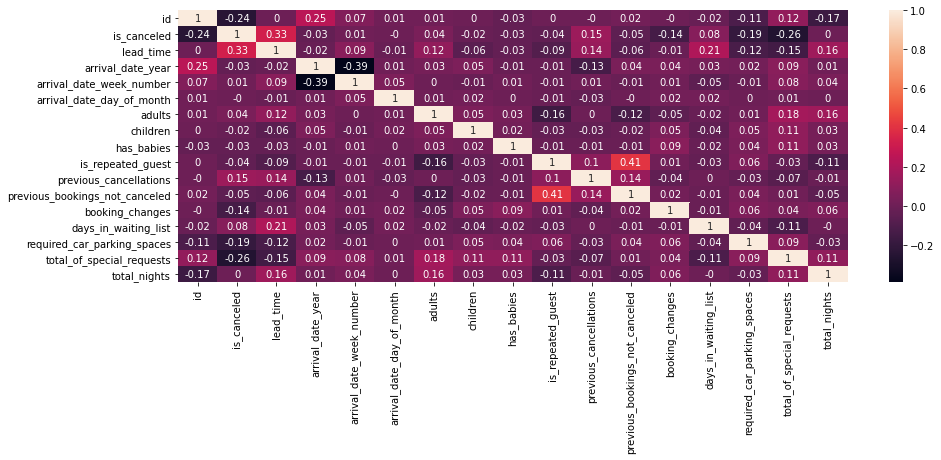

In [22]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr().round(2),annot=True)

Как мы видим, сильное признаки между собой не коррелируют, оценим корреляцию признаков с нашим целевым.

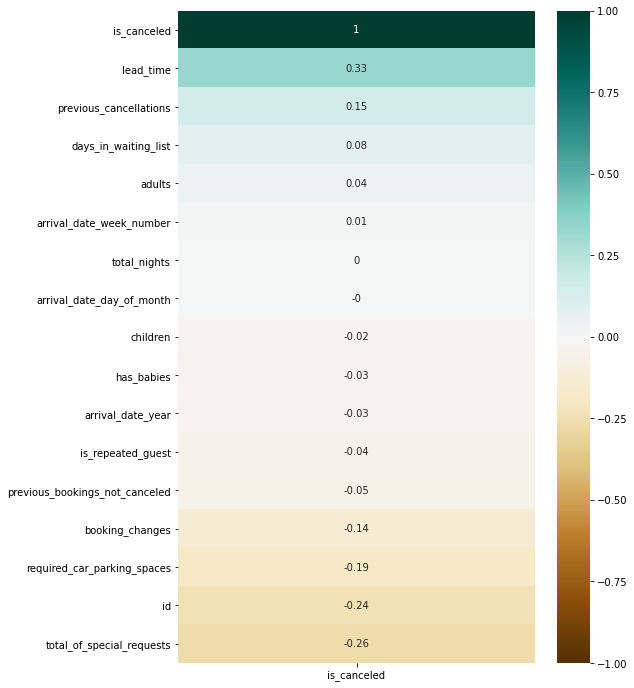

In [23]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr().round(2)[['is_canceled']].sort_values(by='is_canceled', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

По этому графику видно, что есть небольшая связь между `leadd_time` и нашим целевым признаком, так же можно сказать и про `previous_cancellations` и `total_of_special_requests`.

Оценив ранее разброс наших числовых признаков, построим `boxplot` по признакам, что нас интересуют

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lead_time'>

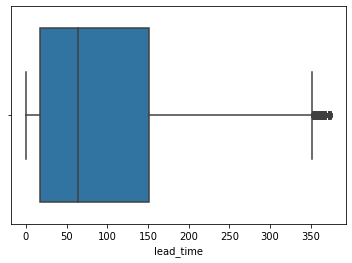

In [24]:
sns.boxplot(df['lead_time'])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_nights'>

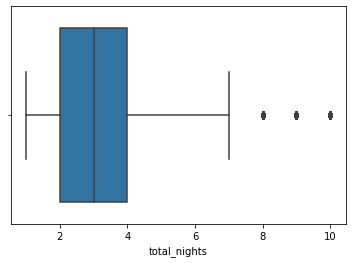

In [25]:
sns.boxplot(df['total_nights'])

Далее построим графики, на которых сравним соотношение по наиболее важным категоральным признакам у отменивших и не отменивших бронирование.

<AxesSubplot:xlabel='reserved_room_type', ylabel='count'>

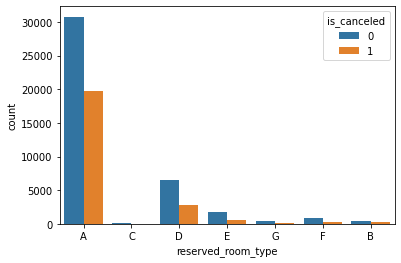

In [26]:
sns.countplot(x="reserved_room_type", hue="is_canceled", data=df)

<AxesSubplot:xlabel='meal', ylabel='count'>

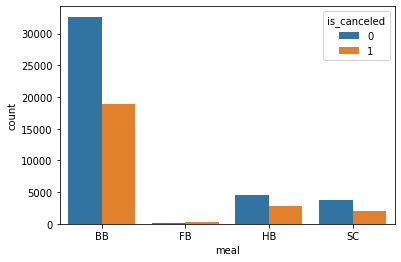

In [27]:
sns.countplot(x="meal", hue="is_canceled", data=df)

<AxesSubplot:xlabel='customer_type', ylabel='count'>

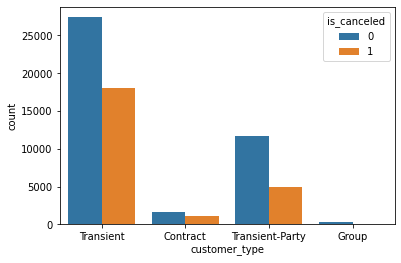

In [28]:
sns.countplot(x="customer_type", hue="is_canceled", data=df)

Видим, что общая тенденция и у тех, и у тех сохраняется.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [29]:
def type_switcher(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        df[column] = df[column].cat.codes

Создали функцию, для изменения типов столбцов.

In [30]:
def season_coef(row):
    if row['arrival_date_month'] in ['June', 'July', 'August']:
        return SUMMER
    elif row['arrival_date_month'] in ['March', 'April', 'May', 'September', 'October', 'November']:
        return OFF_SEASON
    else:
        return 1

Создадим столбец, где будут храниться коэффициенты сезона

In [31]:
df['season'] = df.apply(season_coef, axis=1)

In [32]:
def income(row):
    x = row['total_nights']
    revenue = 0
    if row['is_canceled'] == 0:
        if x >= 2:
            revenue = (row['season'] * x * price_list[row['reserved_room_type']][0] 
                     - price_list[row['reserved_room_type']][1] * (1 + np.floor(x/2)))
        else:
            revenue = (row['season'] * x * price_list[row['reserved_room_type']][0] 
                     - price_list[row['reserved_room_type']][1])
    else:
        revenue = (-1) * (row['season'] * price_list[row['reserved_room_type']][0] 
                     + price_list[row['reserved_room_type']][1])
    return revenue

In [33]:
df['revenue'] = df.apply(income, axis=1)
df.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season,revenue
0,0,0,7.0,2015,July,27,1,1.0,0.0,0.0,...,0,A,0,0,Transient,0,0,1,1.4,1000.0
1,1,0,14.0,2015,July,27,1,2.0,0.0,0.0,...,0,A,0,0,Transient,0,1,2,1.4,2000.0
2,2,0,0.0,2015,July,27,1,2.0,0.0,0.0,...,0,C,0,0,Transient,0,0,2,1.4,980.0
3,3,0,9.0,2015,July,27,1,2.0,0.0,0.0,...,0,C,0,0,Transient,0,1,2,1.4,980.0
4,4,1,85.0,2015,July,27,1,2.0,0.0,0.0,...,0,A,0,0,Transient,0,1,3,1.4,-1800.0


Рассчитали прибыль для каждого заказа.

In [34]:
revenue_no_model = df['revenue'].sum()
print('Прибыль без внедрения модели:',revenue_no_model)

Прибыль без внедрения модели: 65920350.0


In [35]:
buff = df.copy()


In [36]:
replaceable = ['A               ', 'B               ', 'C               ', 'D               ', 'E               ', 'F               ', 'G               ']
replacing = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df_test['reserved_room_type'] = df_test['reserved_room_type'].replace(replaceable, replacing)

In [37]:
buff_test = df_test.copy()


In [38]:
df_test['season'] = df_test.apply(season_coef, axis=1)
df_test['revenue'] = df_test.apply(income, axis=1)

In [39]:
revenue_before = df_test['revenue'].sum()

In [40]:
columns = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
type_switcher(df_test, columns)

### Шаг 4. Разработка модели ML

In [41]:
columns = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
type_switcher(df, columns)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65058 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65058 non-null  int64  
 1   is_canceled                     65058 non-null  int64  
 2   lead_time                       65058 non-null  float64
 3   arrival_date_year               65058 non-null  int64  
 4   arrival_date_month              65058 non-null  int8   
 5   arrival_date_week_number        65058 non-null  int64  
 6   arrival_date_day_of_month       65058 non-null  int64  
 7   adults                          65058 non-null  float64
 8   children                        65058 non-null  float64
 9   has_babies                      65058 non-null  float64
 10  meal                            65058 non-null  int8   
 11  country                         65058 non-null  int16  
 12  distribution_channel            

In [43]:
features = df.drop(['id','revenue','is_canceled','arrival_date_year'], axis=1)
target = df['is_canceled']

Избавимся от этих столбцов, т.к. `id`, `arrival_date_year` не несут никакой смысловой нагрузки для модели, а `revenue` будет отрицательно влиять на модель, т.к. в случае отмены бронироваия этот показатель будет отрицательным. `is_canceled` - наш целевой признак

In [44]:
print(features.shape, target.shape)


(65058, 21) (65058,)


In [45]:
class_frequency = df['is_canceled'].value_counts(normalize=True)
print(class_frequency)

0    0.63116
1    0.36884
Name: is_canceled, dtype: float64


У нас отсутствует явный дизбаланс классов. Метрикой для обучения выберем `f1` меру, т.к. нам важно соблюдать баланс между `precision` и `recall`. 

Метрика `precision` означает точность выявления истинно положительных классов, что для нас важно, это поможет нам не выставлять депозит кому попало и тем самым не отпугивать потенциальных клиентов.

Метрика `recall` покажет насколько модель чувстввительна к истинно положительным результатам, тем самым поможет нам эффективнее выставлять депозит, что, в свою очередь, сохранит нашу прибыль

#### DecisionTreeClassifier

In [46]:
%%time
dtf = DecisionTreeClassifier(random_state=12345)#Исследуем модель дерева решений
param_grid_dtf = { # словарь параметров
    'max_depth':[5,7,9,11,13,15,17,19,20],
    'min_samples_leaf':[1, 2, 3, 4, 6, 8],
    'min_samples_split' : [2, 3, 4, 5]
}

#воспользуемся методом GridSearchCV для подбора параметров
grid_CV_dtf = GridSearchCV(estimator=dtf,
                       param_grid=param_grid_dtf,
                       cv=5,
                       scoring='f1'
)
grid_CV_dtf.fit(features, target)

predictions_tree = grid_CV_dtf.predict(features)

print(grid_CV_dtf.best_score_)

0.589555841895504
CPU times: user 2min 51s, sys: 130 ms, total: 2min 51s
Wall time: 2min 53s


#### LogisticRegression

In [47]:
lr = LogisticRegression(random_state=12345)#Исследуем модель логической регрессии
lr.fit(features, target)

predictions_regression = lr.predict(features)

print(f1_score(target, predictions_regression))

0.6626422425756313


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### RandomForestClassifier

In [48]:
%%time

rfc = RandomForestClassifier(random_state=12345)
param_grid_ = { # словарь параетров
    'max_depth':[5,7,9,11,13,15,17,19,20],
    'min_samples_leaf':[2,4,6,8],    
    'n_estimators': [10, 20, 30, 40, 50],
    'max_features': ['log2'],    
    'criterion' : ['gini']
}

#воспользуемся методом GridSearchCV для подбора параметров
grid_CV_rfc = GridSearchCV(estimator=rfc,
                       param_grid=param_grid_,
                       cv=5,
                       scoring='f1'
)


grid_CV_rfc.fit(features, target)

predictions_forest = grid_CV_rfc.best_estimator_.predict(features)

print(grid_CV_rfc.best_score_)

0.5479440041895404
CPU times: user 12min 42s, sys: 1.07 s, total: 12min 43s
Wall time: 12min 49s


Лучшее значение получили используя `LogisticRegression`, а именно 0.662

Рассчитаем метрику у лучшей модели на тестовых данных.

In [49]:
features_test = df_test.drop(['id','revenue','is_canceled','arrival_date_year'], axis=1)
target_test = df_test['is_canceled']

In [50]:
pred_test = lr.predict(features_test)
print(f1_score(target_test, pred_test))

0.5757948012382685


#### Приминение модели

Теперь используем предсказания модели, чтобы рассчитать прибыль

In [51]:
def income_model(row):
    x = row['total_nights']
    revenue = 0
    if row['is_canceled'] == 0:
        if x >= 2:
            revenue = (row['season'] * x * price_list[row['reserved_room_type']][0] 
                     - price_list[row['reserved_room_type']][1] * (1 + np.floor(x/2)))
        else:
            revenue = (row['season'] * x * price_list[row['reserved_room_type']][0] 
                     - price_list[row['reserved_room_type']][1])
    elif (row['is_canceled']==1)&(row['predictions']==1):
        revenue =(-1) * 0.2 * (row['season'] * price_list[row['reserved_room_type']][0] 
                     + price_list[row['reserved_room_type']][1])
        
    else:
        revenue = (-1) * (row['season'] * price_list[row['reserved_room_type']][0] 
                     + price_list[row['reserved_room_type']][1])
    return revenue

In [52]:
df_test_pred = pd.read_csv('/datasets/hotel_test.csv')
df_test_pred['reserved_room_type'] = df_test_pred['reserved_room_type'].replace(replaceable, replacing)

In [53]:
buff_test['predictions'] = pred_test
buff_test['season'] = buff_test.apply(season_coef, axis=1)
buff_test['revenue'] = buff_test.apply(income_model, axis=1)
revenue_after = buff_test['revenue'].sum()

In [54]:
revenue_after - revenue_before - BUDGET

6664792.0

И того, разница в прибыли между моделью и её отсутствием составила 540216, что означает успешное её применение.

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [55]:
np.array(df.columns)

array(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'adults', 'children', 'has_babies',
       'meal', 'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'season', 'revenue'],
      dtype=object)

In [56]:
df_positive = df[df['is_canceled']==0]
df_negative = df[df['is_canceled']==1]

In [57]:
for column in np.array(df.columns):
    print('Корреляция с', column, df['is_canceled'].corr(df[column]))

Корреляция с id -0.24127704667134323
Корреляция с is_canceled 1.0
Корреляция с lead_time 0.32859729053436537
Корреляция с arrival_date_year -0.030703218488759655
Корреляция с arrival_date_month 0.0011216641723517167
Корреляция с arrival_date_week_number 0.012767152933530639
Корреляция с arrival_date_day_of_month -0.0018290006876693114
Корреляция с adults 0.0444308067823341
Корреляция с children -0.01720090577184351
Корреляция с has_babies -0.03202603719241549
Корреляция с meal -0.0011807935949225924
Корреляция с country 0.31444481979450173
Корреляция с distribution_channel 0.15762923325500275
Корреляция с is_repeated_guest -0.04030959652787355
Корреляция с previous_cancellations 0.15312376586235427
Корреляция с previous_bookings_not_canceled -0.045641372051710954
Корреляция с reserved_room_type -0.08097771409757644
Корреляция с booking_changes -0.14266705655150158
Корреляция с days_in_waiting_list 0.0758535712565088
Корреляция с customer_type -0.06621138836424818
Корреляция с required_

Сравним портреты "надежного" и "ненадежного" клиентов

In [58]:
display_frames([df_positive.describe(), df_negative.describe()])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season,revenue
count,41062.000000,41062.0,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,...,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000,41062.000000
mean,48239.071891,0.0,72.186255,2015.729068,6.121450,31.211802,15.857216,1.825240,0.074570,0.008840,...,0.154328,0.839535,0.257976,2.284204,2.198870,0.089913,0.659369,3.047173,1.215260,2472.162340
std,28270.042938,0.0,81.096123,0.444446,3.708029,13.817230,8.754607,0.493002,0.326144,0.093607,...,1.549591,1.531480,0.661366,16.533465,0.643367,0.287250,0.793697,1.793833,0.129277,1706.561999
min,0.000000,0.0,0.000000,2015.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,200.000000
25%,17346.250000,0.0,8.000000,2015.000000,2.000000,20.000000,8.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,1.200000,1020.000000
50%,61927.000000,0.0,41.000000,2016.000000,7.000000,34.000000,16.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000,1.200000,2000.000000
75%,73487.750000,0.0,110.000000,2016.000000,10.000000,42.000000,23.000000,2.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,1.000000,4.000000,1.200000,3400.000000
max,84121.000000,0.0,373.000000,2016.000000,11.000000,53.000000,31.000000,4.000000,3.000000,1.000000,...,57.000000,6.000000,17.000000,259.000000,3.000000,3.000000,5.000000,10.000000,1.400000,11600.000000


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season,revenue
count,23996.000000,23996.0,23996.000000,23996.00000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,...,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.0,23996.000000,23996.000000,23996.000000,23996.000000
mean,35427.849975,1.0,137.686198,2015.70045,6.130147,31.567970,15.824054,1.868686,0.063136,0.003376,...,0.028671,0.593057,0.082889,5.155318,2.111977,0.0,0.258793,3.052092,1.226354,-1483.229705
std,17559.385381,0.0,105.437528,0.45807,3.796164,12.823504,8.737317,0.431768,0.311169,0.058003,...,0.815567,1.340059,0.427544,20.767979,0.611555,0.0,0.594021,1.639059,0.128397,334.987897
min,4.000000,1.0,0.000000,2015.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,-1800.000000
25%,29386.750000,1.0,45.000000,2015.00000,2.000000,22.000000,8.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,2.000000,1.200000,-1600.000000
50%,37576.500000,1.0,108.000000,2016.00000,6.000000,34.000000,16.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,3.000000,1.200000,-1600.000000
75%,43769.250000,1.0,221.000000,2016.00000,10.000000,42.000000,24.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,4.000000,1.400000,-1400.000000
max,79128.000000,1.0,374.000000,2016.00000,11.000000,53.000000,31.000000,4.000000,3.000000,1.000000,...,58.000000,6.000000,16.000000,236.000000,3.000000,0.0,4.000000,10.000000,1.400000,-500.000000


In [59]:
buff[buff['is_canceled']==1]['country'].value_counts()

PRT    16594
ESP     1078
GBR      935
FRA      874
ITA      763
       ...  
ECU        1
VGB        1
SEN        1
SRB        1
UZB        1
Name: country, Length: 112, dtype: int64

In [60]:
buff[buff['is_canceled']==1]['lead_time'].value_counts()

34.0     249
0.0      242
37.0     222
1.0      222
68.0     221
        ... 
347.0      2
284.0      2
319.0      2
331.0      2
345.0      1
Name: lead_time, Length: 363, dtype: int64

Можем придти к выводу, что портрет "ненадженого" клиента выглядит примерно так:
- Он из Португалии, Испании, Германии
- Просматривается тенденция отмены бронирования, если она совершалась день в день
- Наблюдается явная зависимость от количества потраченных денег на проживание в отеле
Так же сравнив портреты "надежного" и "ненадежного" клиентов, выявили следующую разницу:
- Среднее время нахождения в листе ожидания у "ненадежных" в два раза больше
- "Ненадежные" не запрашивают парковочных мест для машины
- у "надежных" в три раза больше специальных запросов
- "Ненадежные" в среднем бронируют на 65 дней заранее, в сравнении с "надежными"
- Так же "надежные" чаще бронируют с детьми

### Шаг 6.Общий вывод

Мы внедрили модель, которая предсказывает будет ли бронирование отменено, и если будет, то предложит внести депозит.
Мы добились хорошего значения на обучающей метрике, что означает меньшую вероятность, неверного предсказания и соотвественно отпугивания клиента.
Данная модель показала большую разницу в прибыли на тестовой подборке 540 216